In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest, RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

Loading dataset...
Dataset loaded with shape: (2160, 28)

Distribution of anomalies:
is_anomaly
0.0    1836
1.0     324
Name: count, dtype: int64

Types of anomalies:
anomaly_type
normal                               1836
tool_wear                             100
coolant_failure                        95
motor_overheating                      54
power_supply_issue                     39
tool_break                             35
motor_overheating+coolant_failure       1
Name: count, dtype: int64


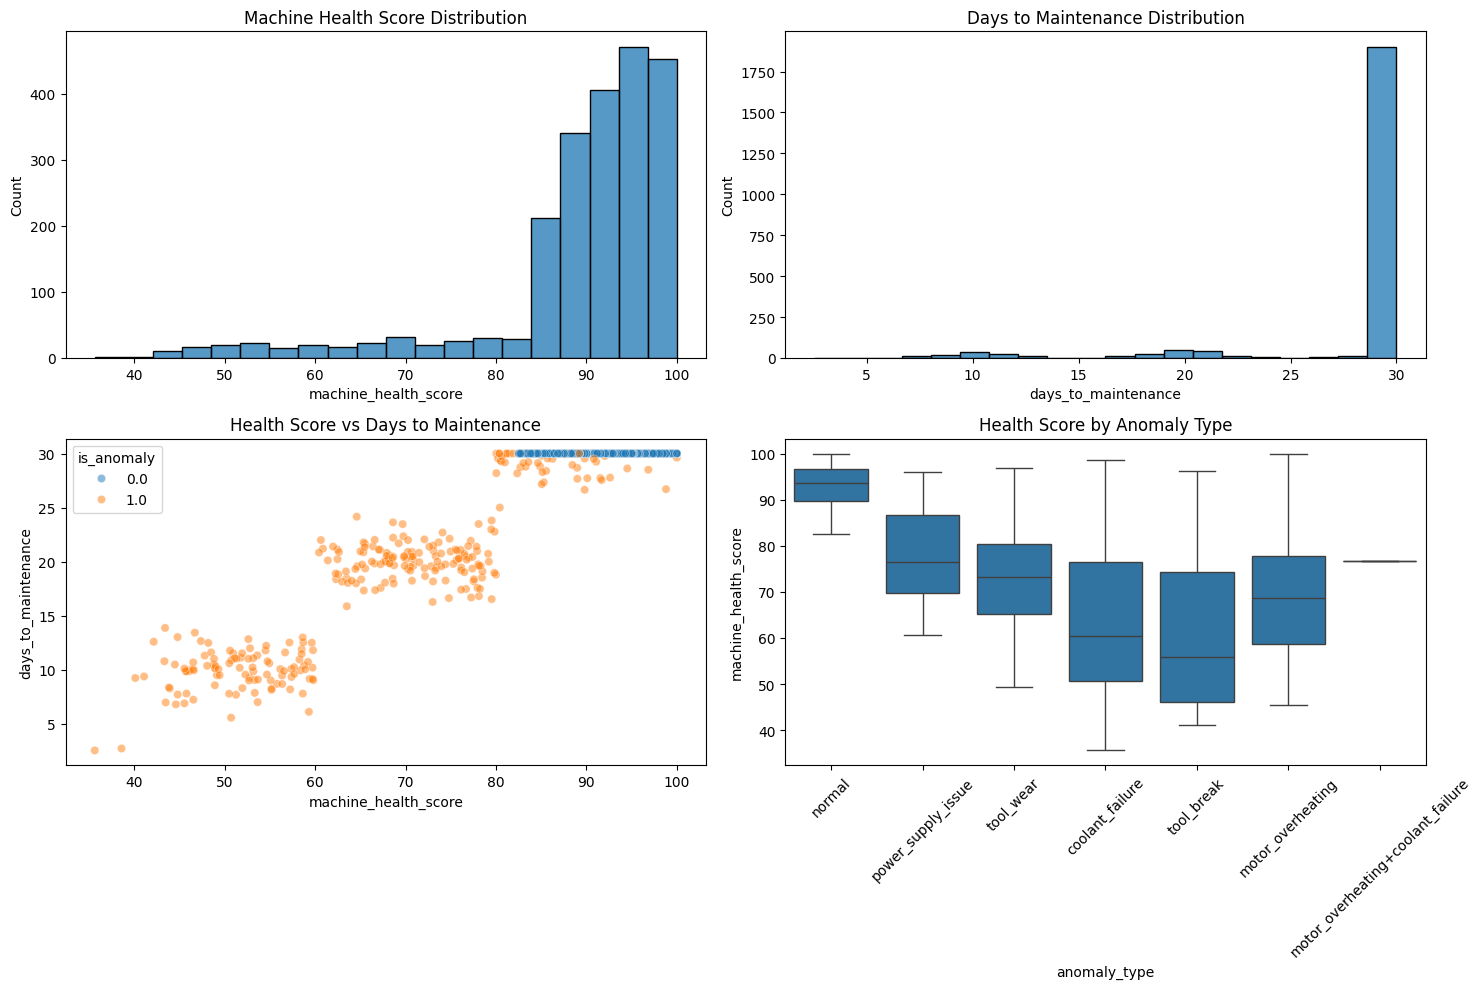

In [47]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
print("Loading dataset...")
df = pd.read_csv("cnc_machine_data.csv")

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Feature Engineering for Time Series
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_of_month'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month

print("Dataset loaded with shape:", df.shape)

# Explore data
print("\nDistribution of anomalies:")
print(df['is_anomaly'].value_counts())

print("\nTypes of anomalies:")
print(df['anomaly_type'].value_counts())

# Plot data distributions to verify we have good variation
plt.figure(figsize=(15, 10))

# Plot health score distribution
plt.subplot(2, 2, 1)
sns.histplot(df['machine_health_score'], bins=20)
plt.title('Machine Health Score Distribution')

# Plot days to maintenance distribution
plt.subplot(2, 2, 2)
sns.histplot(df['days_to_maintenance'], bins=20)
plt.title('Days to Maintenance Distribution')

# Plot health score vs days to maintenance
plt.subplot(2, 2, 3)
sns.scatterplot(x='machine_health_score', y='days_to_maintenance', 
                hue='is_anomaly', data=df, alpha=0.5)
plt.title('Health Score vs Days to Maintenance')

# Plot health score by anomaly type
plt.subplot(2, 2, 4)
sns.boxplot(x='anomaly_type', y='machine_health_score', data=df)
plt.title('Health Score by Anomaly Type')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('data_distributions.png')
plt.show()
plt.close()

# Select features for modeling
feature_columns = [
    'vibration_rms', 'motor_temp_C', 'spindle_current_A', 'rpm', 
    'tool_usage_min', 'coolant_temp_C', 'cutting_force_N', 
    'power_consumption_W', 'acoustic_level_dB', 'machine_hours_today',
    'total_machine_hours', 'vibration_trend', 'motor_temp_trend',
    'power_efficiency', 'tool_wear_rate', 'vibration_std_24h',
    'temp_rate_change', 'current_stability', 'hour', 'day_of_week'
]

<h3> Anomaly Detection Model </h3>

In [48]:
print("\n--- Anomaly Detection Model (Isolation Forest) ---")

# Prepare data for anomaly detection
X_anomaly = df[feature_columns].copy()

# Scale the data
scaler_anomaly = StandardScaler()
X_anomaly_scaled = scaler_anomaly.fit_transform(X_anomaly)
X_anomaly_scaled = pd.DataFrame(X_anomaly_scaled)
X_anomaly_scaled = X_anomaly_scaled.fillna(X_anomaly_scaled.mean())
X_anomaly_scaled = X_anomaly_scaled.values

# Split data
X_train_anomaly, X_test_anomaly, y_train_anomaly, y_test_anomaly = train_test_split(
    X_anomaly_scaled, df['is_anomaly'].values, test_size=0.2, random_state=42
)

# Train Isolation Forest model
contamination = float(df['is_anomaly'].mean())
print(f"Using contamination value: {contamination:.4f}")

iso_forest = IsolationForest(
    n_estimators=200,
    max_samples='auto',
    contamination=contamination,
    random_state=42
)

print("Training Isolation Forest model...")
iso_forest.fit(X_train_anomaly)

# Predict anomalies
# Convert to binary labels (1 for inliers, -1 for outliers, so we need to flip and adjust to 0, 1)
y_pred_train = (iso_forest.predict(X_train_anomaly) == -1).astype(int)
y_pred_test = (iso_forest.predict(X_test_anomaly) == -1).astype(int)

# Evaluate model
train_accuracy = accuracy_score(y_train_anomaly, y_pred_train)
test_accuracy = accuracy_score(y_test_anomaly, y_pred_test)
test_precision = precision_score(y_test_anomaly, y_pred_test)
test_recall = recall_score(y_test_anomaly, y_pred_test)
test_f1 = f1_score(y_test_anomaly, y_pred_test)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Calculate anomaly scores
# Lower scores (more negative) indicate higher likelihood of being an anomaly
anomaly_scores = iso_forest.decision_function(X_anomaly_scaled)

# Add anomaly scores to the dataframe for further analysis
df['anomaly_score'] = anomaly_scores
df['predicted_anomaly'] = (iso_forest.predict(X_anomaly_scaled) == -1).astype(int)

# Additional analysis - Random Forest for anomaly type classification
print("\n--- Anomaly Type Classification (Random Forest) ---")

# Only use instances that are anomalies for training anomaly type classifier
anomaly_df = df[df['is_anomaly'] == 1].copy()
X_type = anomaly_df[feature_columns]
y_type = anomaly_df['anomaly_type']

# print(y_type.value_counts())
# # Split data
# X_train_type, X_test_type, y_train_type, y_test_type = train_test_split(
#     X_type, y_type, test_size=0.3, random_state=42, stratify=y_type
# )

X_train_type, X_test_type, y_train_type, y_test_type = train_test_split(
    X_type, y_type, test_size=0.3, random_state=42
)


# Train Random Forest for anomaly type classification
rf_type = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_type.fit(X_train_type, y_train_type)

# Predict and evaluate
y_pred_type = rf_type.predict(X_test_type)
type_accuracy = accuracy_score(y_test_type, y_pred_type)

print(f"Anomaly Type Classification Accuracy: {type_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_type, y_pred_type))


--- Anomaly Detection Model (Isolation Forest) ---
Using contamination value: 0.1500
Training Isolation Forest model...
Train Accuracy: 0.8895
Test Accuracy: 0.9005
Test Precision: 0.5962
Test Recall: 0.5849
Test F1 Score: 0.5905

--- Anomaly Type Classification (Random Forest) ---
Anomaly Type Classification Accuracy: 0.9694

Classification Report:
                                   precision    recall  f1-score   support

                  coolant_failure       0.97      1.00      0.98        28
                motor_overheating       0.94      0.94      0.94        18
motor_overheating+coolant_failure       0.00      0.00      0.00         1
               power_supply_issue       1.00      0.92      0.96        12
                       tool_break       1.00      1.00      1.00        10
                        tool_wear       0.97      1.00      0.98        29

                         accuracy                           0.97        98
                        macro avg       0.81 

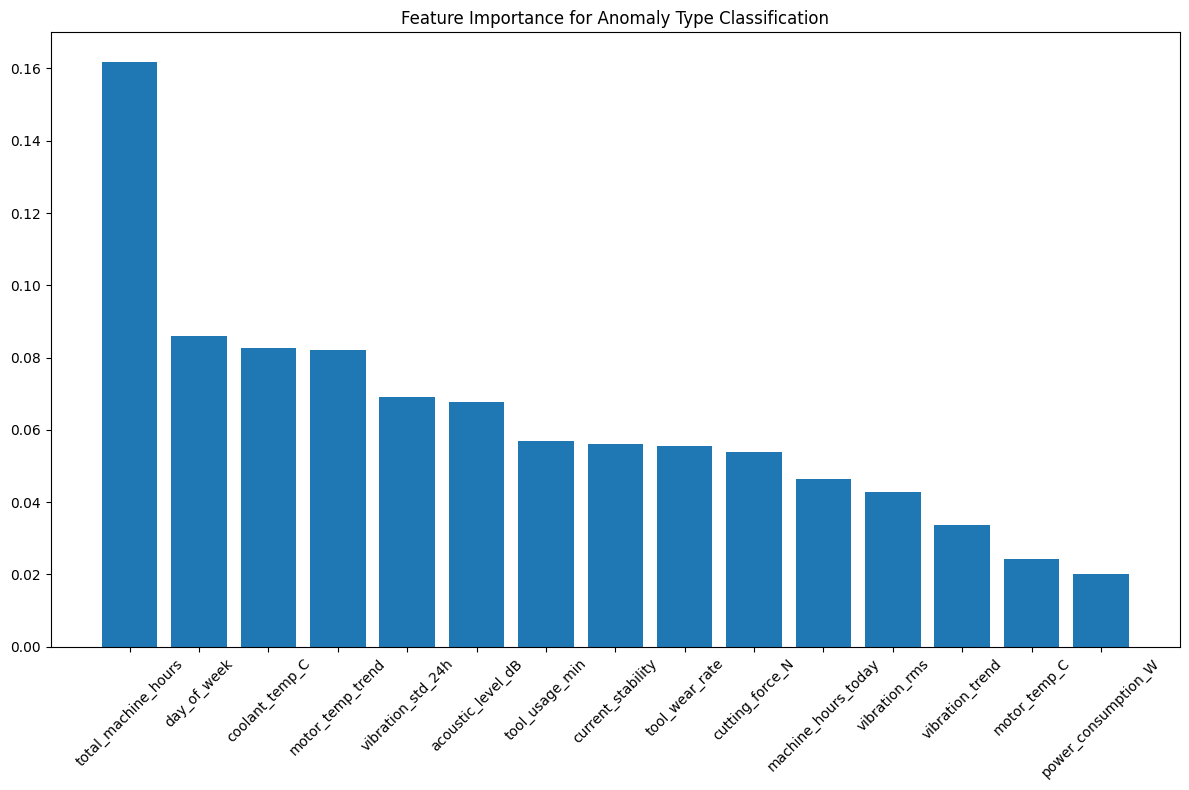

In [49]:
# Plot feature importance for anomaly type classification
plt.figure(figsize=(12, 8))
importance = rf_type.feature_importances_
indices = np.argsort(importance)[::-1]
plt.bar(range(len(indices[:15])), importance[indices[:15]])
plt.xticks(range(len(indices[:15])), [feature_columns[i] for i in indices[:15]], rotation=45)
plt.title('Feature Importance for Anomaly Type Classification')
plt.tight_layout()
plt.savefig('anomaly_type_feature_importance.png')
plt.show()
plt.close()

<h3> Improved Maintenance Prediction Model - LSTM </H3>

In [50]:
print("\n--- Improved Maintenance Prediction Model (LSTM) ---")

# Prepare data for maintenance prediction
X_maint = df[feature_columns].copy()
y_maint = df['days_to_maintenance'].values

# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_maint_scaled = scaler_X.fit_transform(X_maint)
y_maint_scaled = scaler_y.fit_transform(y_maint.reshape(-1, 1))

# Create sequences for LSTM with more context
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Define sequence length - increase for more context
time_steps = 48  # Use 48 hours of data to predict maintenance

# Create sequences
X_seq, y_seq = create_sequences(X_maint_scaled, y_maint_scaled, time_steps)

# Try stratified sampling with appropriate settings and fallback option
try:
    # Use quantile strategy and fewer bins
    from sklearn.preprocessing import KBinsDiscretizer
    discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
    y_binned = discretizer.fit_transform(y_seq).flatten()
    
    X_train_maint, X_test_maint, y_train_maint, y_test_maint = train_test_split(
        X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_binned
    )
    print("Using stratified sampling for train/test split.")
except ValueError:
    # Fall back to regular split
    print("Warning: Stratified split failed. Using regular train_test_split instead.")
    X_train_maint, X_test_maint, y_train_maint, y_test_maint = train_test_split(
        X_seq, y_seq, test_size=0.2, random_state=42
    )


--- Improved Maintenance Prediction Model (LSTM) ---
Using stratified sampling for train/test split.


In [51]:
# Build improved LSTM model with more complex architecture
def build_advanced_lstm_model(input_shape):
    model = Sequential()
    
    # First LSTM layer with more units
    model.add(Bidirectional(LSTM(128, return_sequences=True, input_shape=input_shape)))
    model.add(Dropout(0.3))
    
    # Second LSTM layer
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))
    
    # Third LSTM layer
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    
    # Dense layers for prediction
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    
    # Use a lower learning rate for better convergence
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Set up early stopping with more patience
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Train LSTM model with more epochs
print("Training improved LSTM model for maintenance prediction...")
lstm_model = build_advanced_lstm_model((time_steps, X_maint_scaled.shape[1]))
lstm_history = lstm_model.fit(
    X_train_maint, y_train_maint,
    epochs=200,  # Increase epochs
    batch_size=64,  # Larger batch size
    validation_split=0.15,
    callbacks=[early_stopping],
    verbose=1
)


Training improved LSTM model for maintenance prediction...
Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.3508 - val_loss: 0.0335
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0583 - val_loss: 0.0315
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0471 - val_loss: 0.0311
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0484 - val_loss: 0.0313
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0444 - val_loss: 0.0303
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0433 - val_loss: 0.0317
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0387 - val_loss: 0.0303
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0392 - val_loss: 0.0286
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0398 - val_loss: 0.0273
Epoch 10/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0364 - val_loss: 0.0269
Epoch 11/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0330 - val_loss: 

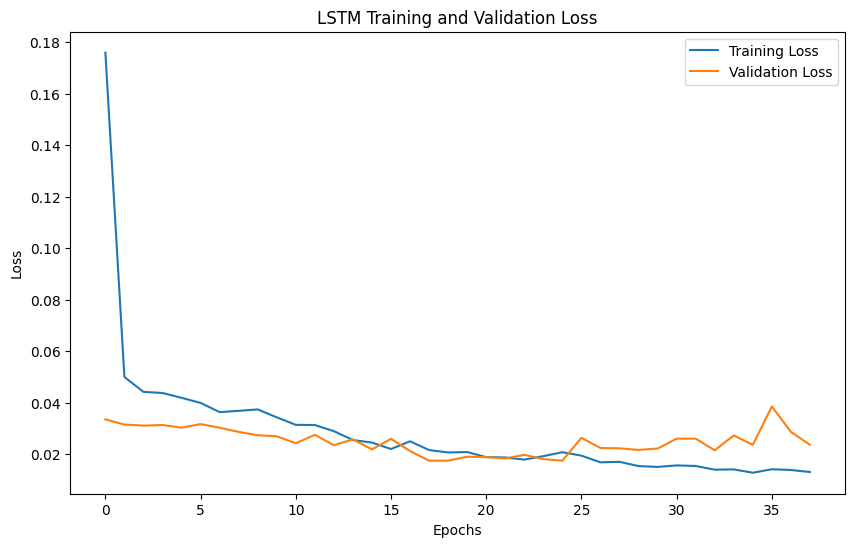

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Maintenance Prediction RMSE: 4.08 days
Maintenance Prediction R²: 0.3578


In [53]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('lstm_training_history.png')
plt.show()
plt.close()

# Evaluate LSTM model
y_pred_maint_scaled = lstm_model.predict(X_test_maint)
y_pred_maint = scaler_y.inverse_transform(y_pred_maint_scaled)
y_test_maint_orig = scaler_y.inverse_transform(y_test_maint)

maint_mse = mean_squared_error(y_test_maint_orig, y_pred_maint)
maint_rmse = np.sqrt(maint_mse)
maint_r2 = r2_score(y_test_maint_orig, y_pred_maint)

print(f"Maintenance Prediction RMSE: {maint_rmse:.2f} days")
print(f"Maintenance Prediction R²: {maint_r2:.4f}")

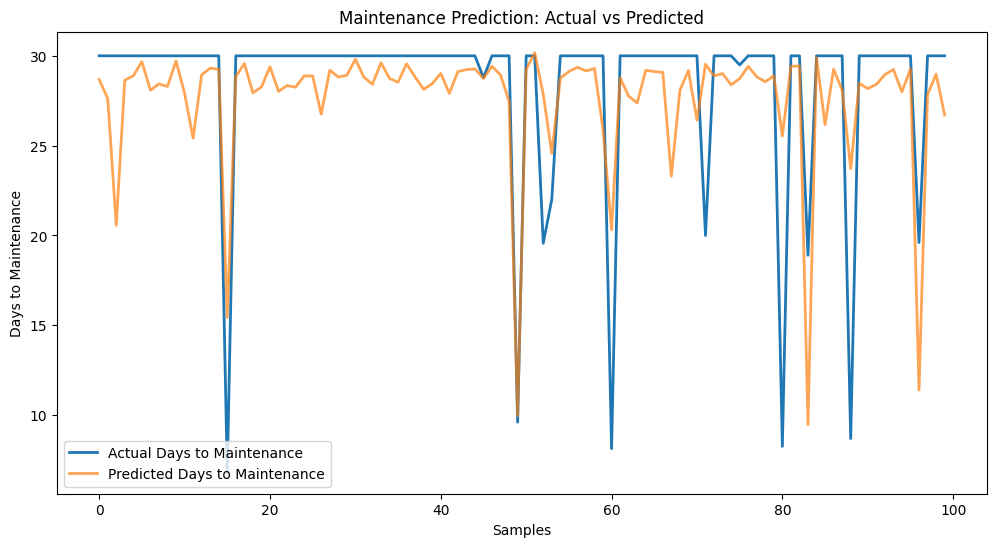


Trying Random Forest as alternative for maintenance prediction...
Random Forest Maintenance Prediction RMSE: 2.13 days
Random Forest Maintenance Prediction R²: 0.7465
Using LSTM for maintenance prediction as it performs better


In [57]:
# Plot predictions vs actual with better visualization
# plt.figure(figsize=(12, 6))
# # Sort by actual values for better visualization
# sorted_indices = np.argsort(y_test_maint_orig.flatten())
# plt.plot(y_test_maint_orig[sorted_indices][:100], label='Actual Days to Maintenance', linewidth=2)
# plt.plot(y_pred_maint[sorted_indices][:100], label='Predicted Days to Maintenance', linewidth=2, alpha=0.7)
# plt.title('Maintenance Prediction: Actual vs Predicted (Sorted)')
# plt.xlabel('Samples (Sorted by Actual Value)')
# plt.ylabel('Days to Maintenance')
# plt.legend()
# plt.savefig('maintenance_prediction_sorted.png')
# plt.show()
# plt.close()

plt.figure(figsize=(12, 6))
plt.plot(y_test_maint_orig[:100], label='Actual Days to Maintenance', linewidth=2)
plt.plot(y_pred_maint[:100], label='Predicted Days to Maintenance', linewidth=2, alpha=0.7)
plt.title('Maintenance Prediction: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Days to Maintenance')
plt.legend()
plt.savefig('maintenance_prediction.png')
plt.show()
plt.close()

# Also try Random Forest as an alternative model
print("\nTrying Random Forest as alternative for maintenance prediction...")
rf_maint = RandomForestRegressor(
    n_estimators=200, 
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Prepare data for RF (no sequences needed)
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(
    X_maint_scaled, y_maint_scaled, test_size=0.2, random_state=42
)

# Train Random Forest
rf_maint.fit(X_rf_train, y_rf_train.ravel())

# Predict and evaluate
y_rf_pred_scaled = rf_maint.predict(X_rf_test).reshape(-1, 1)
y_rf_pred = scaler_y.inverse_transform(y_rf_pred_scaled)
y_rf_test_orig = scaler_y.inverse_transform(y_rf_test)

rf_mse = mean_squared_error(y_rf_test_orig, y_rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_rf_test_orig, y_rf_pred)

print(f"Random Forest Maintenance Prediction RMSE: {rf_rmse:.2f} days")
print(f"Random Forest Maintenance Prediction R²: {rf_r2:.4f}")

# Use the better model (LSTM or RF) based on R² score
if rf_r2 > maint_r2:
    print("Using Random Forest for maintenance prediction as it performs better")
    maint_model = "random_forest"
    maint_rmse = rf_rmse
    maint_r2 = rf_r2
else:
    print("Using LSTM for maintenance prediction as it performs better")
    maint_model = "lstm"


<H3>Machine Health Prediction Model</H3>

In [58]:
print("\n--- Machine Health Score Prediction Model (Random Forest) ---")

# Prepare data for health score prediction
X_health = df[feature_columns].copy()
y_health = df['machine_health_score'].values

# Split the data
X_train_health, X_test_health, y_train_health, y_test_health = train_test_split(
    X_health, y_health, test_size=0.2, random_state=42
)

# Train Random Forest Regressor
rf_health = RandomForestRegressor(n_estimators=100, random_state=42)
rf_health.fit(X_train_health, y_train_health)

# Predict and evaluate
y_pred_health = rf_health.predict(X_test_health)
health_mse = mean_squared_error(y_test_health, y_pred_health)
health_rmse = np.sqrt(health_mse)
health_r2 = r2_score(y_test_health, y_pred_health)

print(f"Health Score Prediction RMSE: {health_rmse:.4f}")
print(f"Health Score Prediction R²: {health_r2:.4f}")


--- Machine Health Score Prediction Model (Random Forest) ---
Health Score Prediction RMSE: 3.5609
Health Score Prediction R²: 0.8749


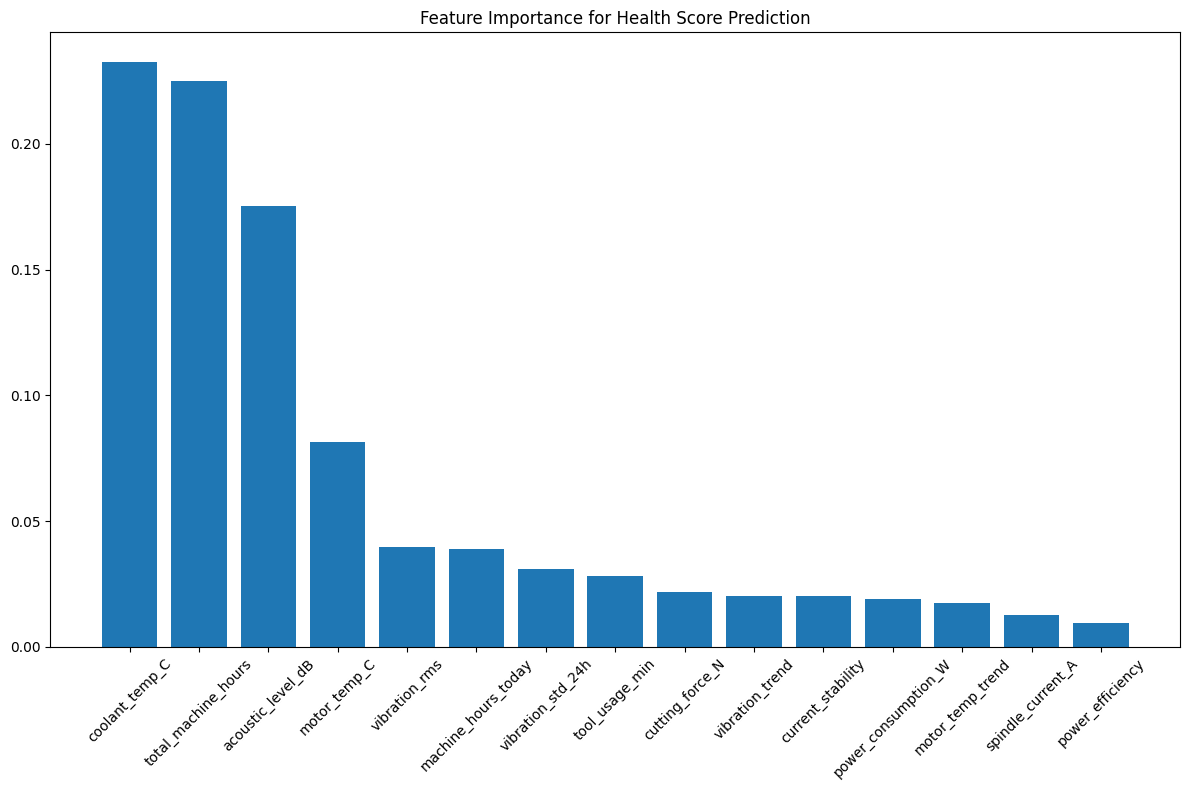

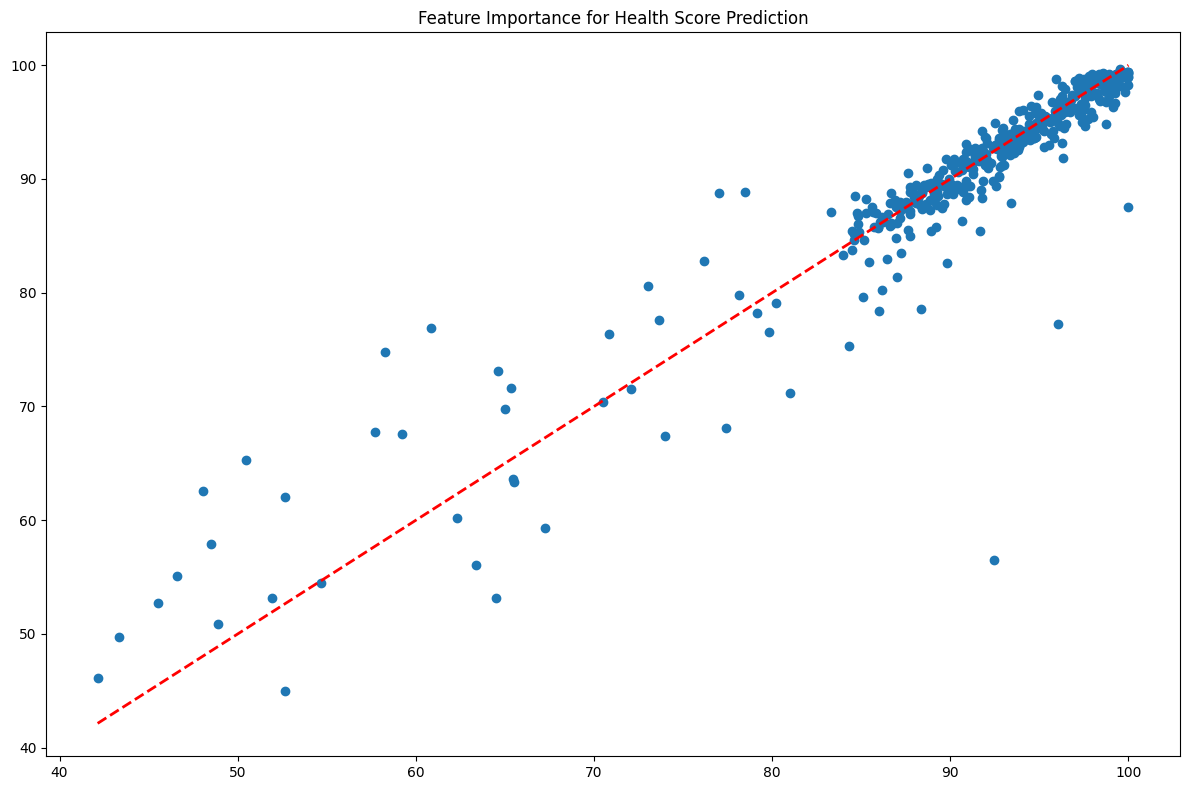

In [59]:
# Feature importance for health score prediction
plt.figure(figsize=(12, 8))
importance_health = rf_health.feature_importances_
indices_health = np.argsort(importance_health)[::-1]
plt.bar(range(len(indices_health[:15])), importance_health[indices_health[:15]])
plt.xticks(range(len(indices_health[:15])), [feature_columns[i] for i in indices_health[:15]], rotation=45)
plt.title('Feature Importance for Health Score Prediction')
plt.tight_layout()
plt.savefig('health_score_feature_importance.png')
plt.show()
plt.close()


plt.figure(figsize=(12, 8))
importance_health = rf_health.feature_importances_
indices_health = np.argsort(importance_health)[::-1]
plt.scatter(y_test_health, y_pred_health)
plt.plot([y_test_health.min(), y_test_health.max()], 
         [y_test_health.min(), y_test_health.max()], 
         'r--', linewidth=2)
plt.title('Feature Importance for Health Score Prediction')
plt.tight_layout()
plt.savefig('health_score_prediction.png')
plt.show()
plt.close()

<h3>Save models and results</h3>

In [60]:
print("\n--- Saving models and results ---")

# Save models using joblib for sklearn models
import joblib
joblib.dump(iso_forest, 'isolation_forest_model.pkl')
joblib.dump(rf_type, 'anomaly_type_classifier.pkl')
joblib.dump(rf_health, 'health_score_predictor.pkl')

# Save the LSTM model
lstm_model.save('maintenance_predictor_lstm.h5')

# Save scalers
joblib.dump(scaler_anomaly, 'scaler_anomaly.pkl')
joblib.dump(scaler_X, 'scaler_X_maint.pkl')
joblib.dump(scaler_y, 'scaler_y_maint.pkl')

# Create a summary dataframe with all predictions for further analysis
df_results = df.copy()
df_results['predicted_days_to_maintenance'] = np.nan
df_results['predicted_health_score'] = np.nan

# Fill in predictions where available (not all rows due to sequence requirements)
start_idx = time_steps
for i in range(len(y_pred_maint)):
    true_idx = i + start_idx + len(X_train_maint)
    if true_idx < len(df_results):
        df_results.loc[true_idx, 'predicted_days_to_maintenance'] = y_pred_maint[i][0]

# Add health score predictions
df_results['predicted_health_score'] = np.nan
test_indices = df.index[:-len(X_test_health)]
# df_results.loc[test_indices, 'predicted_health_score'] = y_pred_health
df_results.loc[X_test_health.index, 'predicted_health_score'] = y_pred_health

# Save the results dataframe
df_results.to_csv('cnc_machine_predictions.csv', index=False)

print("\nAnalysis complete. Models and results saved successfully.")


--- Saving models and results ---

Analysis complete. Models and results saved successfully.


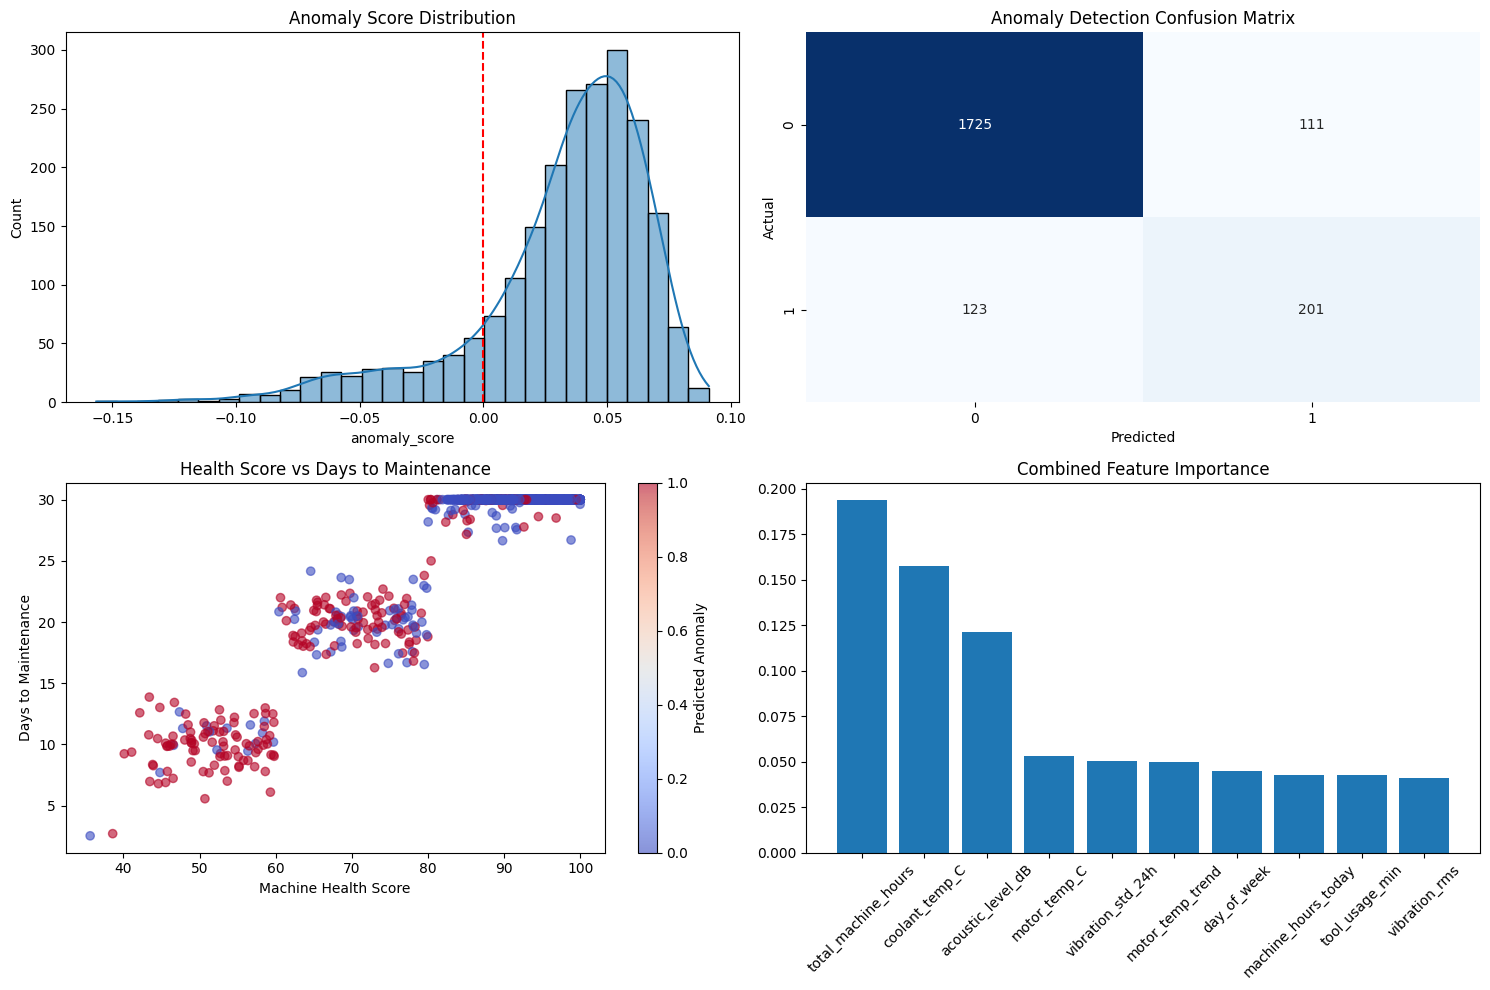


Final dashboard saved. Analysis complete!


In [61]:
# Final visualization - Combined dashboard
plt.figure(figsize=(15, 10))

# Plot 1: Anomaly Score Distribution
plt.subplot(2, 2, 1)
sns.histplot(df['anomaly_score'], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Anomaly Score Distribution')

# Plot 2: Confusion Matrix for Anomaly Detection
plt.subplot(2, 2, 2)
cm = confusion_matrix(df['is_anomaly'], df['predicted_anomaly'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Anomaly Detection Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot 3: Days to Maintenance vs Health Score with Anomalies
plt.subplot(2, 2, 3)
scatter = plt.scatter(df['machine_health_score'], df['days_to_maintenance'], 
                      c=df['predicted_anomaly'], cmap='coolwarm', alpha=0.6)
plt.colorbar(scatter, label='Predicted Anomaly')
plt.title('Health Score vs Days to Maintenance')
plt.xlabel('Machine Health Score')
plt.ylabel('Days to Maintenance')

# Plot 4: Feature Importance Summary
plt.subplot(2, 2, 4)
# Combine feature importances from all models
combined_importance = np.zeros(len(feature_columns))
for i, imp in enumerate([rf_type.feature_importances_, rf_health.feature_importances_]):
    # Normalize and add
    combined_importance += imp / np.sum(imp)
combined_importance /= 2  # Average across models

# Sort and plot
indices_combined = np.argsort(combined_importance)[::-1]
plt.bar(range(10), combined_importance[indices_combined[:10]])
plt.xticks(range(10), [feature_columns[i] for i in indices_combined[:10]], rotation=45)
plt.title('Combined Feature Importance')

plt.tight_layout()
plt.savefig('cnc_machine_analysis_dashboard.png')
plt.show()
plt.close()

print("\nFinal dashboard saved. Analysis complete!")